# Neural Network Models

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [41]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import random
from tqdm import tqdm
import sys

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [42]:
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

In [43]:
#MONTHLY DATA
X_mef_m = pd.read_csv(f'{DATA_PATH}/processed/mef_monthly_data_processed.csv')
X_mai_m = pd.read_csv(f'{DATA_PATH}/processed/mai_monthly_data_processed.csv')
y_mkt_m = pd.read_csv(f'{DATA_PATH}/processed/mkt_monthly_data_processed.csv')

X_mef_m['date'] = pd.to_datetime(X_mef_m['date'])
X_mai_m['date'] = pd.to_datetime(X_mai_m['date'])
y_mkt_m['date'] = pd.to_datetime(y_mkt_m['date'])

# Drop the 'date' column from each dataset
X_mef_m = X_mef_m.drop('date', axis=1)
X_mai_m = X_mai_m.drop('date', axis=1)
y_mkt_m = y_mkt_m.drop('date', axis=1)

X_mef_m = X_mef_m.values
X_mai_m = X_mai_m.values
y_mkt_m = y_mkt_m.values

#DAILY DATA
X_mef_d = pd.read_csv(f'{DATA_PATH}/processed/mef_daily_data_processed.csv')
X_mai_d = pd.read_csv(f'{DATA_PATH}/processed/mai_daily_data_processed.csv')
y_mkt_d = pd.read_csv(f'{DATA_PATH}/processed/mkt_daily_data_processed.csv')

X_mef_d['date'] = pd.to_datetime(X_mef_d['date'])
X_mai_d['date'] = pd.to_datetime(X_mai_d['date'])
y_mkt_d['date'] = pd.to_datetime(y_mkt_d['date'])

# Drop the 'date' column from each dataset
X_mef_d = X_mef_d.drop('date', axis=1)
X_mai_d = X_mai_d.drop('date', axis=1)
y_mkt_d = y_mkt_d.drop('date', axis=1)

X_mef_d = X_mef_d.values
X_mai_d = X_mai_d.values
y_mkt_d = y_mkt_d.values

Now we define functions for train-test split, the network architecture and training of the model (seperately for MEF and MAI datasets) and to test the trained models.

In [44]:
# Function: split data into training and test set based on the random state
def split_data(X, y, test_size, random_state):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    return X_train, y_train, X_test, y_test

In [45]:
# Function: build the neural network model for MAI data

def train_neural_network_MAI(X, y):
    """
    Parameters:
    - X: MAI features
    - y: Target variable

    Returns:
    - Trained model
    - Model training history
    """

    # the best number of layers, dropout layers, the best number of units of a layer have been selected
    model = keras.Sequential([
    layers.Dense(64, activation=keras.layers.ELU(),input_dim=8),
    Dropout(0.3),
    layers.Dense(32, activation=keras.layers.ELU()),
    Dropout(0.5),
    layers.Dense(1)  # Output layer with 1 neuron for numerical output
    ])

    # Compile the model
    # the best optimizer and learning rate have been selected
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    # Train the model
    # the best number of epochs and batch_size have been selected
    epochs = 10  # Define the number of epochs

    # Suppress the verbose output of model.fit()
    history = model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

    # Custom progress bar
    with tqdm(total=epochs, file=sys.stdout, desc="Training Progress", bar_format='{l_bar}{bar} {n_fmt}/{total_fmt}') as pbar:
        for epoch in range(epochs):
            # Insert any per-epoch logic or checks if necessary
            pbar.update(1)

    mse_values = history.history['loss']
    mse_values_val = history.history['val_loss']

    avg_RMSE_train = np.mean([mse_value ** 0.5 for mse_value in mse_values])
    avg_RMSE_test = np.mean([mse_value_val ** 0.5 for mse_value_val in mse_values_val])

    return model, history, avg_RMSE_train, avg_RMSE_test

In [46]:
# Function: build the neural network model for MEF data

def train_neural_network_MEF(X, y):
    """
    Parameters:
    - X: MEF features
    - y: Target variable

    Returns:
    - Trained model
    - Model training history
    """

    # the best number of layers, dropout layers, the best number of units of a layer have been selected
    model = keras.Sequential([
    layers.Dense(64, activation=keras.layers.ELU(),input_dim=14),
    Dropout(0.3),
    layers.Dense(32, activation=keras.layers.ELU()),
    Dropout(0.5),
    layers.Dense(1)  # Output layer with 1 neuron for numerical output
    ])

    # Compile the model
    # the best optimizer and learning rate have been selected
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
    
    epochs = 10  # Define the number of epochs
    
    # Train the model
    # the best number of epochs and batch_size have been selected
    history = model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

    # Custom progress bar
    with tqdm(total=epochs, file=sys.stdout, desc="Training Progress", bar_format='{l_bar}{bar} {n_fmt}/{total_fmt}') as pbar:
        for epoch in range(epochs):
            # Insert any per-epoch logic or checks if necessary
            pbar.update(1)
    
    mse_values = history.history['loss']
    mse_values_val = history.history['val_loss']

    avg_RMSE_train = np.mean([mse_value ** 0.5 for mse_value in mse_values])
    avg_RMSE_test = np.mean([mse_value_val ** 0.5 for mse_value_val in mse_values_val])

    return model, history, avg_RMSE_train, avg_RMSE_test

In [47]:
#Function: evaluate the performance of the model and show the values in plot
def test_model(model, X_test, y_test):
    """
    Test a trained model and calculate regression metrics.

    Parameters:
    - model: Trained model
    - X_test: Testing features
    - y_test: True values for testing

    Returns:
    - Mean Squared Error (MSE)
    - Mean Absolute Error (MAE)
    - R-squared (R2) score
    """

    # Make y_pred using the trained model
    y_pred = model.predict(X_test)

    # Calculate regression metrics
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    # Plot predicted values and true values

    new_y_test = [value for index, value in enumerate(y_test)]
    plt.plot(new_y_test, label='True',color='blue')
    plt.plot(y_pred, label='Prediction',color='red')

    plt.xlabel('Index')
    plt.ylabel('y values')
    plt.title('True vs Pred')

    plt.legend()

    plt.show()

    return MSE, MAE, R2

## Neural Networks with monthly data

As a first approach, we will try to train the Neural Networks using the datasets with monthly data. However we do not expect these models to perform efficiently due to the small size of the datasets (408 points), which is not sufficient for the complexity of a neural network.

In order to achieve more robust results, we will train the networks 10 times over different train-test splits and report the average RMSE.

We start with the MAI data.

Training Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.184438088608566 , average validation RMSE is 62.939318190343485
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


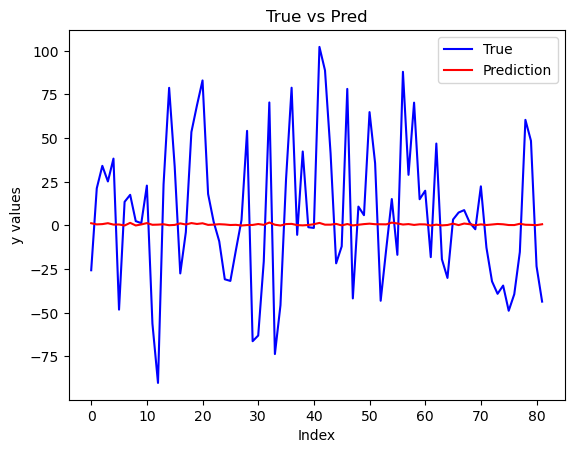

RMSE: 42.49405396125002, MAE: 33.96955473142766, R2: -0.01638416405080445
Training Iterations:  10%|█         | 1/10 [00:05<00:51,  5.76s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.19242133654335 , average validation RMSE is 39.82673530520627
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


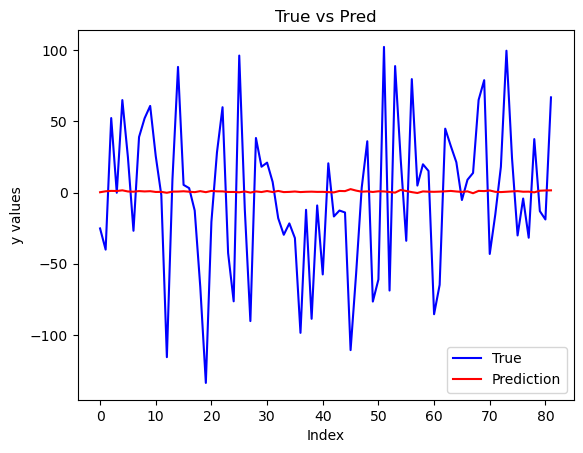

RMSE: 52.395543759803125, MAE: 41.40989558163927, R2: -0.0022296436843571854
Training Iterations:  20%|██        | 2/10 [00:07<00:28,  3.61s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 47.81041450642077 , average validation RMSE is 51.68823281738347
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


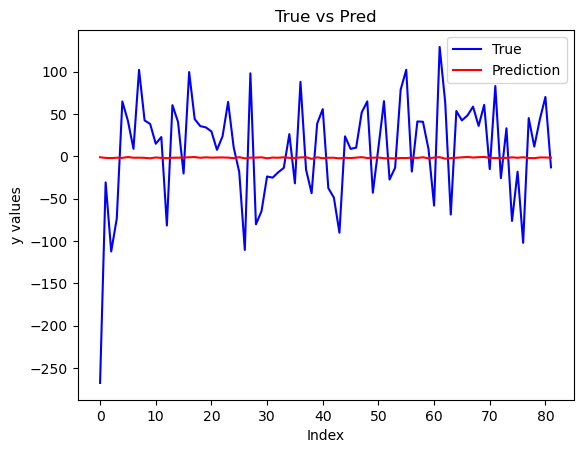

RMSE: 62.72287027980483, MAE: 49.92404764793252, R2: -0.024779949872999918
Training Iterations:  30%|███       | 3/10 [00:10<00:21,  3.04s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.952482739599155 , average validation RMSE is 44.10359676610308
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


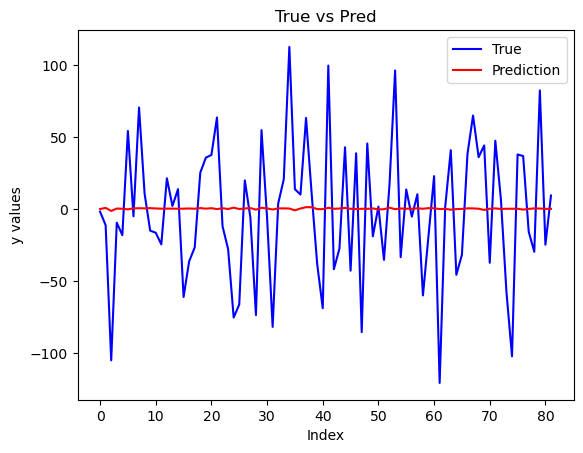

RMSE: 47.4983144791629, MAE: 37.748945866214086, R2: 0.002914524219081671
Training Iterations:  40%|████      | 4/10 [00:12<00:16,  2.79s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 53.195393047139575 , average validation RMSE is 42.33799754892886
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


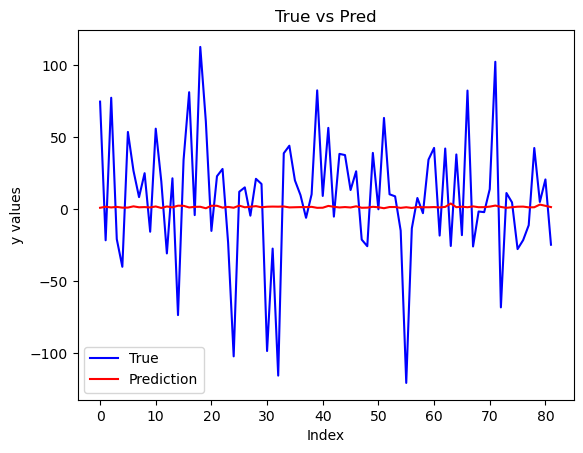

RMSE: 44.63237903380596, MAE: 33.53902900977793, R2: -0.02554861180254253
Training Iterations:  50%|█████     | 5/10 [00:14<00:12,  2.56s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.88904584804258 , average validation RMSE is 46.50807276009216
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


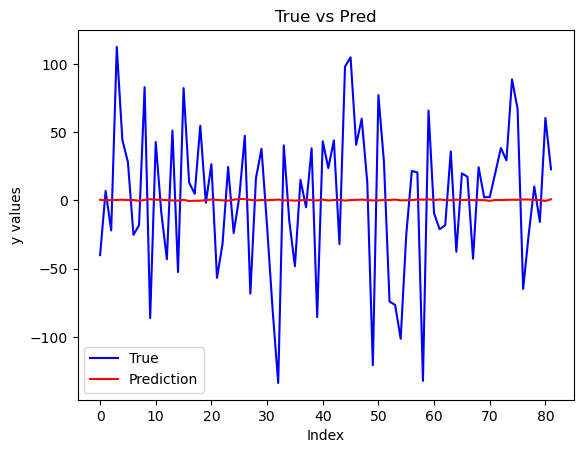

RMSE: 53.361742145346035, MAE: 42.84756590775762, R2: -0.0022636682027210586
Training Iterations:  60%|██████    | 6/10 [00:17<00:09,  2.46s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 49.23651913077999 , average validation RMSE is 57.01301725276098
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


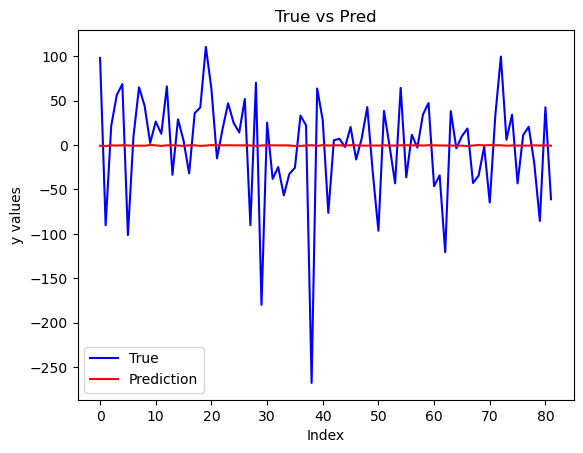

RMSE: 59.848121673640726, MAE: 44.00671149588379, R2: -0.0010255076391259
Training Iterations:  70%|███████   | 7/10 [00:19<00:07,  2.45s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 49.88955343768943 , average validation RMSE is 51.68378652334625
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


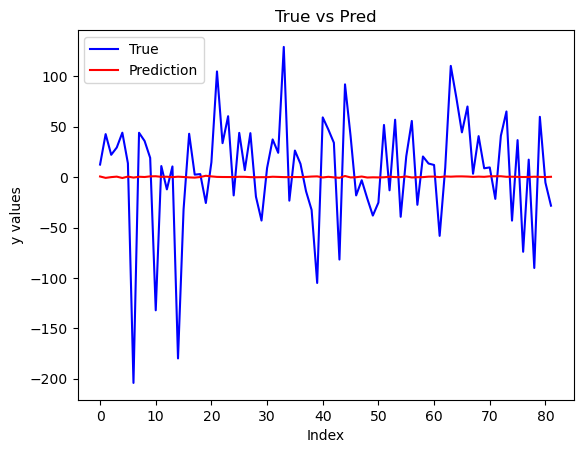

RMSE: 55.98319146304433, MAE: 41.53516341633682, R2: -0.013226974411280956
Training Iterations:  80%|████████  | 8/10 [00:21<00:04,  2.34s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.81001733157924 , average validation RMSE is 40.1729021912126
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


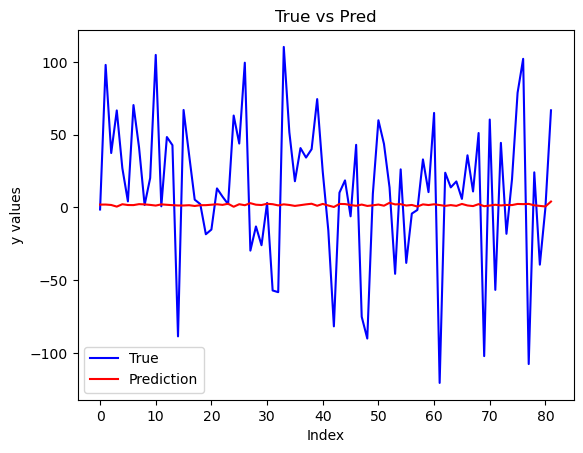

RMSE: 50.84435814418841, MAE: 39.540366761931146, R2: -0.050076608042863846
Training Iterations:  90%|█████████ | 9/10 [00:23<00:02,  2.30s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 51.94219529328785 , average validation RMSE is 43.724383845265535
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


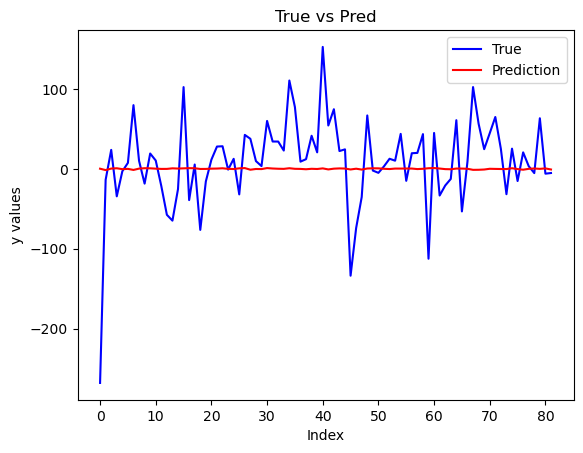

RMSE: 56.11995280117654, MAE: 38.732576374596306, R2: -0.0247471423240464
Training Iterations: 100%|██████████| 10/10 [00:25<00:00,  2.60s/it]
 
 
The average test RMSE over 10 iterations for MAI monthly data is: 52.590052774122285
 
 


In [56]:
# Test the performance of the model on 10 different random train-test splits of MAI monthly data, and report the average RMSE.
list_RMSE_train_train=[]
list_RMSE_train_val=[]
list_RMSE=[]

np.random.seed(11)
random.seed(11)

# Use tqdm for the outer loop to track progress of iterations
for i in tqdm(range(10), desc="Training Iterations", file=sys.stdout):
    # Generate training and test data sets
    X_train, y_train, X_test, y_test = split_data(X_mai_m, y_mkt_m, 0.2, i)

    # Train the model
    trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MAI(X_train, y_train)
    print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
    list_RMSE_train_train.append(avg_RMSE_train)
    list_RMSE_train_val.append(avg_RMSE_test)

    # Evaluate the model
    MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
    print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
    list_RMSE.append(MSE**(1/2))

# Calculate and print average RMSE
avg_RMSE = np.mean(list_RMSE)
print(' ')
print(' ')
print('The average test RMSE over 10 iterations for MAI monthly data is:', avg_RMSE)
print(' ')
print(' ')

Text(0.5, 1.0, 'Distribution of RMSE over Iterations (MAI monthly training data)')

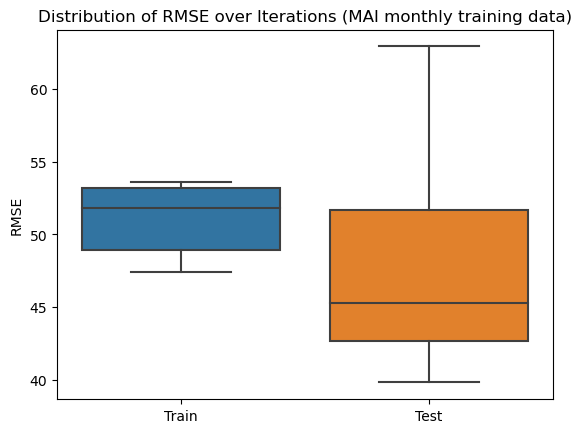

In [49]:
sns.boxplot(data=[list_RMSE_train_train, list_RMSE_train_val])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MAI monthly training data)')

The standard variation of RMSE is 6.119499898322955


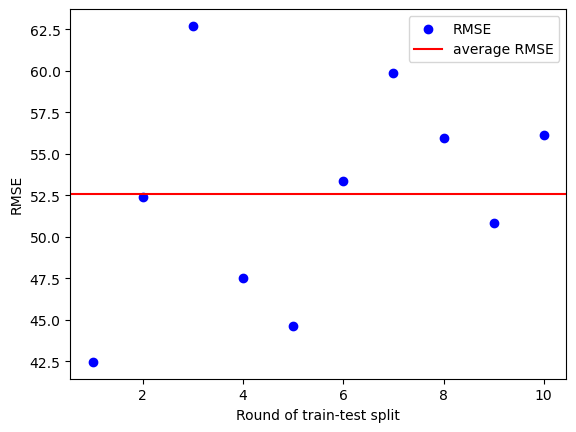

In [50]:
# Calculate the standard variation of RMSE
print('The standard variation of RMSE is', np.std(list_RMSE))
# Plot the RMSE of each round of random split
plt.scatter(y=list_RMSE,x=range(1,11),label='RMSE',color='blue')
plt.axhline(y=avg_RMSE, label='average RMSE',linestyle='-',color='red')

plt.xlabel('Round of train-test split')
plt.ylabel('RMSE')
#plt.title('RMSE of each round of random split, NN on MAI monthly')

plt.legend()

plt.show()

Now we do the same with the MEF monthly data.

Training Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 51.373449231570376 , average validation RMSE is 63.042961866365964
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


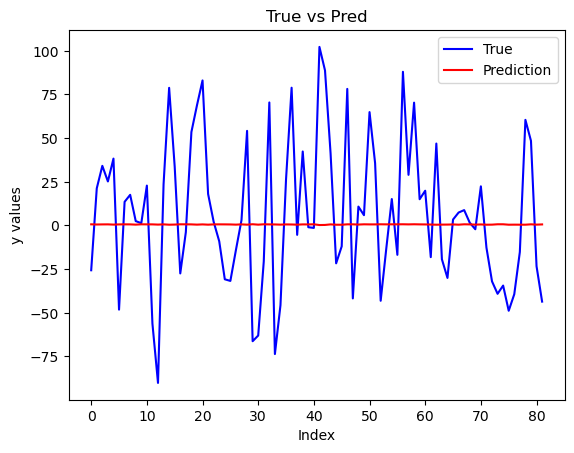

RMSE: 42.61792821769409, MAE: 34.07272848571922, R2: -0.022318516352991313
Training Iterations:  10%|█         | 1/10 [00:02<00:19,  2.21s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 55.33394098947233 , average validation RMSE is 39.909368647775295
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


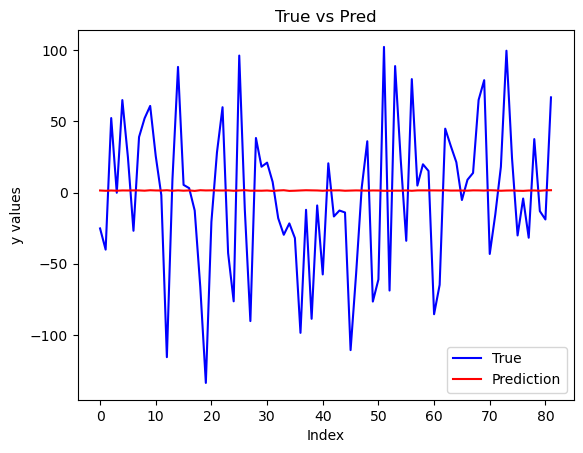

RMSE: 52.48192836362154, MAE: 41.43236810179369, R2: -0.005537122697615526
Training Iterations:  20%|██        | 2/10 [00:04<00:17,  2.20s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 46.23530131794811 , average validation RMSE is 51.761173565931564
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


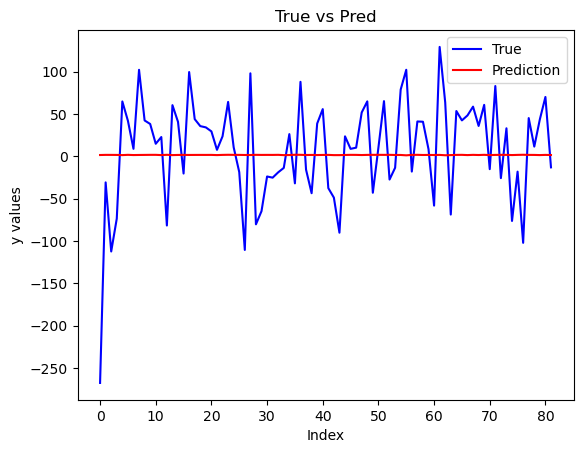

RMSE: 62.3359345522887, MAE: 49.27297604495416, R2: -0.012175268335720357
Training Iterations:  30%|███       | 3/10 [00:06<00:15,  2.23s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 53.741076453525544 , average validation RMSE is 44.082707669566155
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


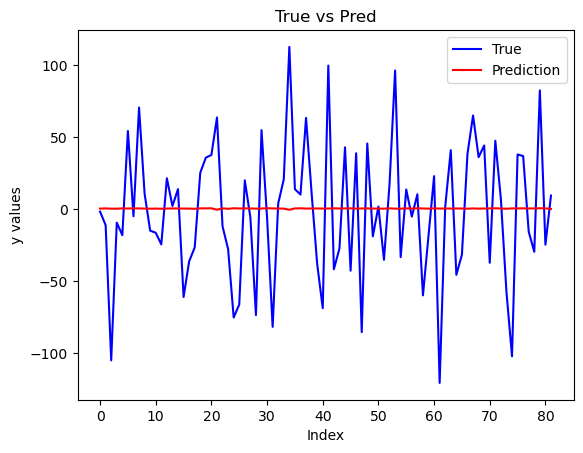

RMSE: 47.63959707759085, MAE: 37.80462565838325, R2: -0.003025911220357669
Training Iterations:  40%|████      | 4/10 [00:08<00:13,  2.26s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 53.63814182757098 , average validation RMSE is 42.621986223774044
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


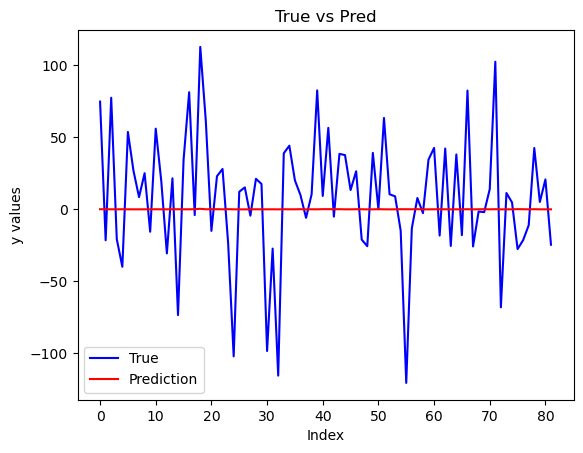

RMSE: 44.83680968006218, MAE: 33.78745531231852, R2: -0.03496481189744882
Training Iterations:  50%|█████     | 5/10 [00:11<00:11,  2.36s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 51.64873379726801 , average validation RMSE is 46.79247332723577
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


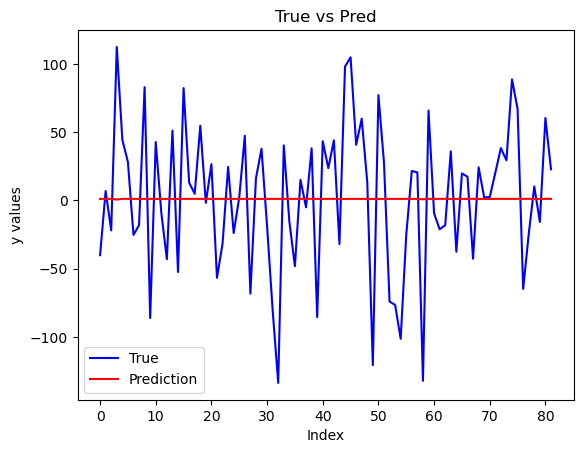

RMSE: 53.318659142469656, MAE: 42.700897434351354, R2: -0.0006459137854804009
Training Iterations:  60%|██████    | 6/10 [00:13<00:09,  2.29s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 46.79957068294924 , average validation RMSE is 56.210633251274785
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


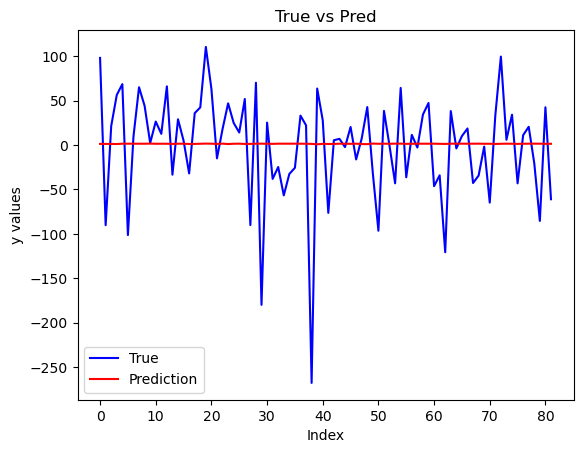

RMSE: 59.878345328056525, MAE: 43.66081032263963, R2: -0.0020368105019761273
Training Iterations:  70%|███████   | 7/10 [00:15<00:06,  2.26s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 49.214142059009326 , average validation RMSE is 51.93937789932702
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


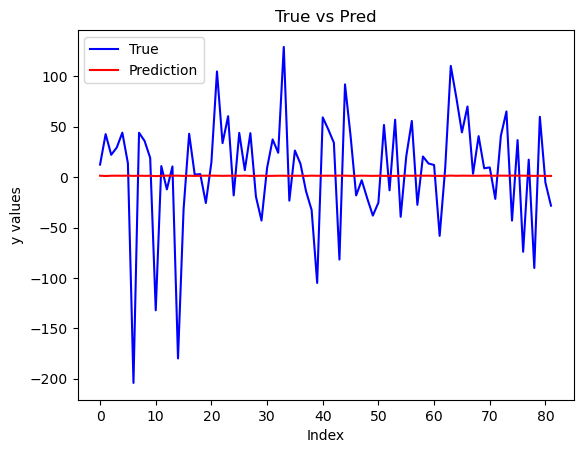

RMSE: 55.8581544662935, MAE: 41.20505850689709, R2: -0.008705996802176763
Training Iterations:  80%|████████  | 8/10 [00:18<00:04,  2.26s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.35813876406651 , average validation RMSE is 40.051187184711
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


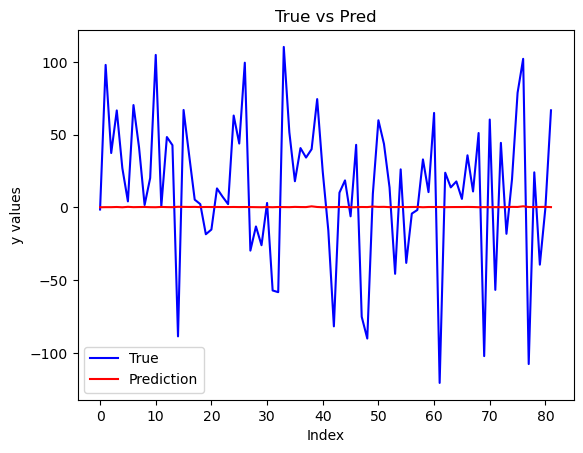

RMSE: 51.25250697925302, MAE: 40.14812681453987, R2: -0.06700307876060618
Training Iterations:  90%|█████████ | 9/10 [00:20<00:02,  2.29s/it]

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Progress: 100%|██████████ 10/10[A
During training of this NN model, average training RMSE is 52.1281568045966 , average validation RMSE is 44.285955729440985
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


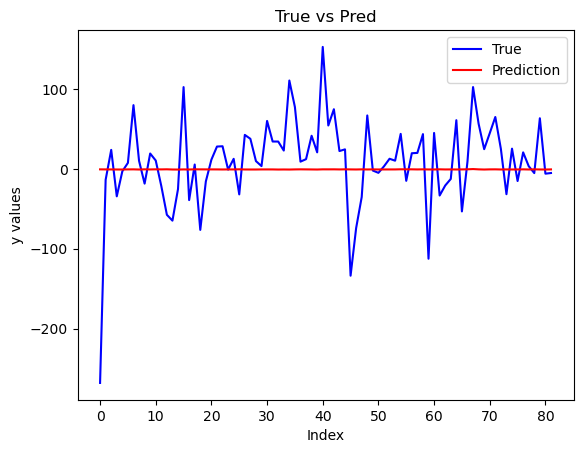

RMSE: 56.22761168107817, MAE: 38.933081817763515, R2: -0.028682603576214216
Training Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]
 
The average test RMSE over 10 iterations for MEF monthly data is: 52.644747548840826


In [55]:
# Test the performance of the model on 10 different random train-test splits of MEF monthly data, and report the average RMSE.
list_RMSE_train_train2=[]
list_RMSE_train_val2=[]
list_RMSE2=[]

np.random.seed(11)
random.seed(11)

# Use tqdm for the outer loop to track progress of iterations
for i in tqdm(range(10), desc="Training Iterations", file=sys.stdout):
    # Generate training and test data sets
    X_train, y_train, X_test, y_test = split_data(X_mef_m, y_mkt_m, 0.2, i)

    # Use X_train and y_train as MAI features and target variable
    trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MEF(X_train, y_train)
    print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
    list_RMSE_train_train2.append(avg_RMSE_train)
    list_RMSE_train_val2.append(avg_RMSE_test)

    # Have the performance of the trained model evaluated on the test set
    MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
    print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
    list_RMSE2.append(MSE**(1/2))
avg_RMSE2=np.mean(list_RMSE2)
print(' ')
print(' ')
print('The average test RMSE over 10 iterations for MEF monthly data is:', avg_RMSE2)
print(' ')
print(' ')

Text(0.5, 1.0, 'Distribution of RMSE over Iterations (MEF monthly training data)')

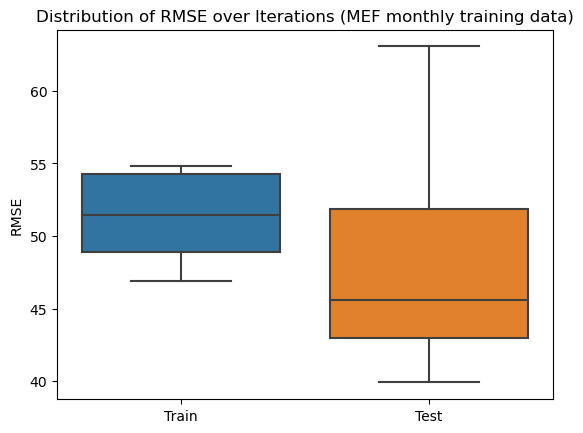

In [52]:
sns.boxplot(data=[list_RMSE_train_train2, list_RMSE_train_val2])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MEF monthly training data)')

## Neural Networks with daily data

Now we will train again using the daily datasets. Since the size of them seems sufficient enough for getting robust results from the training of the networks, we will do only do one training.

We start with the MAI daily dataset.

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Progress: 100%|██████████ 10/10
During training of this NN model, average training RMSE is 54.96522688437267 , average validation RMSE is 53.401868159292846
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


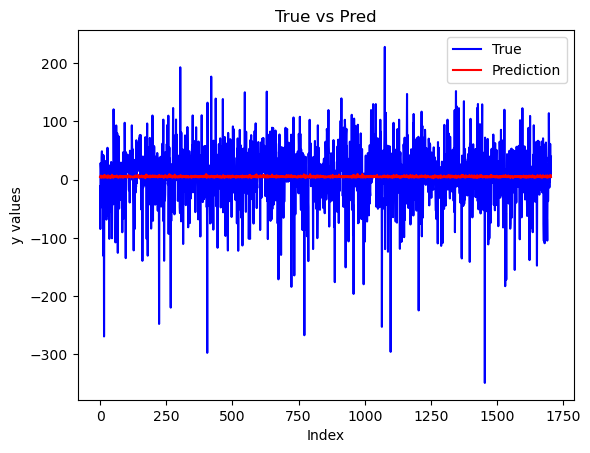

RMSE: 54.164545718391565, MAE: 39.54262279118628, R2: -0.001707883360612561
 
The test RMSE for MAI daily data is: 54.164545718391565


In [53]:
# Test the performance of the model on 10 different random train-test splits of MAI daily data, and report the average RMSE.
list_RMSE_train_train1=[]
list_RMSE_train_val1=[]
list_RMSE1=[]
num_iterations = 1

for i in range(0,num_iterations):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mai_d, y_mkt_d, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MAI(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train1.append(avg_RMSE_train)
  list_RMSE_train_val1.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE1.append(MSE**(1/2))
avg_RMSE1=np.mean(list_RMSE1)
print(' ')
print(' ')
print('The test RMSE for MAI daily data is:', avg_RMSE1)
print(' ')
print(' ')

Now we do the same for the MEF daily data.

C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Progress: 100%|██████████ 10/10
During training of this NN model, average training RMSE is 54.90625831392102 , average validation RMSE is 53.34870980469416
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


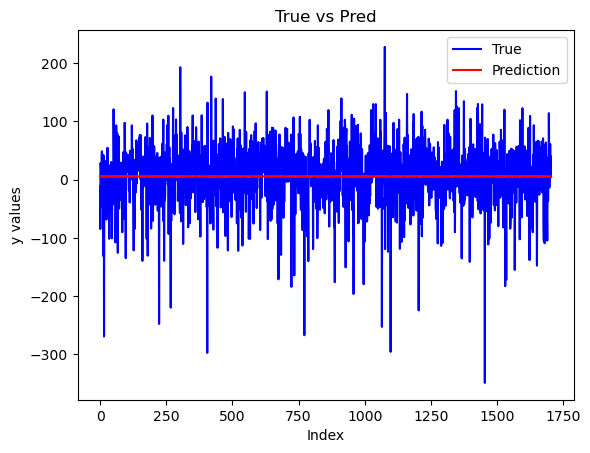

RMSE: 54.15699703441381, MAE: 39.529147760807355, R2: -0.0014286952224398242
 
The test RMSE for MEF daily data is: 54.15699703441381


In [54]:
# Test the performance of the model on 10 different random train-test splits of MEF daily data, and report the average RMSE.
list_RMSE_train_train3=[]
list_RMSE_train_val3=[]
list_RMSE3=[]
num_iterations = 1

for i in range(0,num_iterations):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mef_d, y_mkt_d, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MEF(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train3.append(avg_RMSE_train)
  list_RMSE_train_val3.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE3.append(MSE**(1/2))
avg_RMSE3=np.mean(list_RMSE3)
print(' ')
print(' ')
print('The test RMSE for MEF daily data is:', avg_RMSE3)
print(' ')
print(' ')